<a href="https://colab.research.google.com/github/RoshanPatel7580/pneumonia-detection/blob/main/trial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
pip install pydicom

In [22]:
import tensorflow
tensorflow.__version__

'2.3.0'

In [23]:
import glob, pylab, pandas as pd
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
%matplotlib inline 

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
IS_LOCAL = False
import os
if(IS_LOCAL):
    PATH="/content/drive/My Drive/Colab Notebooks/capstone/rsna-pneumonia-detection-challenge"
else:
    PATH="../content/drive/My Drive/Colab Notebooks/capstone/rsna-pneumonia-detection-challenge"
print(os.listdir(PATH))

['stage_2_detailed_class_info.csv', 'GCP Credits Request Link - RSNA.txt', 'stage_2_sample_submission.csv', 'stage_2_train_labels.csv', 'stage_2_test_images', '.ipynb_checkpoints', 'stage_2_train_images', 'trial 1.ipynb', 'trial 2.ipynb']


In [26]:
class_info_df = pd.read_csv(PATH+'/stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv(PATH+'/stage_2_train_labels.csv') 

In [27]:
print(f"Detailed class info -  rows: {class_info_df.shape[0]}, columns: {class_info_df.shape[1]}")
print(f"Train labels -  rows: {train_labels_df.shape[0]}, columns: {train_labels_df.shape[1]}")

Detailed class info -  rows: 30227, columns: 2
Train labels -  rows: 30227, columns: 6


In [28]:
class_info_df.sample(10)

,patientId,class
11127,745ce781-5c87-4075-be9a-a221afd1b7e5,No Lung Opacity / Not Normal
24117,d8ddfa54-02ce-446b-a4c8-a7d20044bbc6,No Lung Opacity / Not Normal
6209,4d27d505-8df2-41a1-9ee1-5e2119a99117,No Lung Opacity / Not Normal
14059,8bd6bfaa-af66-435f-95c3-99c9f5e7074b,Lung Opacity
13064,83edc889-292c-456e-bc3e-6e21de8bc26a,No Lung Opacity / Not Normal
14930,92c29872-e308-4d66-86b0-a20a290ee9ab,No Lung Opacity / Not Normal
13005,83700f47-c0b3-46a5-9067-29e45d31599e,Normal
3950,3bbcfb90-b950-4502-9866-82a131651a73,Normal
912,0b63ee7f-9715-4a4a-a892-2ea49adbed2e,No Lung Opacity / Not Normal
30190,c109061a-d815-4cae-8343-9230d8024adf,Lung Opacity


In [29]:
train_labels_df.sample(10)

,patientId,x,y,width,height,Target
15111,9426dee9-b77d-41bf-b319-6baf65ab5400,NaN,NaN,NaN,NaN,0
22284,c9a95d7f-8a6f-49c5-88d3-8a1cfaaf51a4,203.0,412.0,218.0,303.0,1
18544,aeaf6ffd-ff7e-48cc-b31f-175a5e79b415,NaN,NaN,NaN,NaN,0
26233,ea585bb9-bb93-41fa-b0e5-c3bbe4d50188,NaN,NaN,NaN,NaN,0
4779,4151bad2-b56a-4c0a-9794-28b48548e5d4,NaN,NaN,NaN,NaN,0
29682,2178c094-b206-4fe5-a9ef-d84540996b89,231.0,589.0,189.0,228.0,1
4813,41869b8c-c1be-4a54-ad93-5a042e1018bc,NaN,NaN,NaN,NaN,0
14067,8be844aa-e84b-4496-b67e-707e6074ca30,NaN,NaN,NaN,NaN,0
25105,e1297bf9-390d-4d7e-b902-4b02005a0d4f,200.0,527.0,149.0,93.0,1
8305,5e5b0c0c-3df3-43d9-8a8e-530a2343bffc,NaN,NaN,NaN,NaN,0


In [30]:
##Data exploration

In [31]:
##missing data

In [32]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return np.transpose(pd.concat([total, percent], axis=1, keys=['Total', 'Percent']))
missing_data(train_labels_df)

,height,width,y,x,Target,patientId
Total,20672.000000,20672.000000,20672.000000,20672.000000,0.0,0.0
Percent,68.389188,68.389188,68.389188,68.389188,0.0,0.0


In [33]:
missing_data(class_info_df)

,class,patientId
Total,0.0,0.0
Percent,0.0,0.0


In [34]:
##The percent missing for x,y, height and width in train labels represents the percent of the target 0 (not Lung opacity)
##class distribution from class detailed info

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


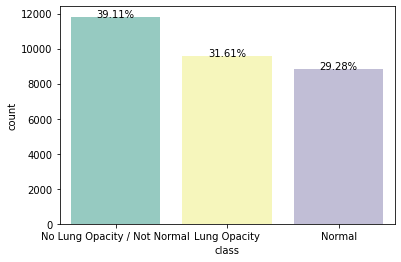

In [35]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(class_info_df))
sns.countplot(class_info_df['class'],order = class_info_df['class'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center") 
plt.show()

In [46]:
## more detail bifergation

In [47]:
def get_feature_distribution(data, feature):
    # Get the count for each label
    label_counts = data[feature].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    print("Feature: {}".format(feature))
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))

get_feature_distribution(class_info_df, 'class')

Feature: class
No Lung Opacity / Not Normal  :   11821 or 39.1%
Lung Opacity                  :   9555 or 31.61%
Normal                        :   8851 or 29.28%


In [48]:
## In the train set, the percent of data with value for Target = 1 is therefore 30.92%.

In [49]:
##  Merge train and class detail info data

In [50]:
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [51]:
train_class_df.sample(10)

,patientId,x,y,width,height,Target,class
25900,bb51a303-4438-43ae-b843-415616c99b0d,179.0,629.0,219.0,140.0,1,Lung Opacity
23510,b0e900dd-5c9c-4764-a429-3f18f056b4a1,217.0,602.0,197.0,152.0,1,Lung Opacity
23554,b1185bf9-79d4-4497-ac44-cd2581128f5b,166.0,410.0,231.0,217.0,1,Lung Opacity
12869,6db5a292-f0b6-4e23-baff-001031e582c5,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
23783,b2103ba0-f721-45a3-876e-c4e53ebfe890,214.0,161.0,236.0,657.0,1,Lung Opacity
36915,229c584f-7174-4fcf-b740-7127cbf53525,283.0,600.0,142.0,218.0,1,Lung Opacity
10397,5bad55a2-06e1-4ee9-8fbd-555a1f75e647,642.0,184.0,226.0,410.0,1,Lung Opacity
16344,847f25e9-6983-4c5f-a1e6-f3629557f1a3,657.0,701.0,310.0,310.0,1,Lung Opacity
10505,5c65a8b2-7873-4490-9fce-ac4fe0417ada,728.0,440.0,160.0,343.0,1,Lung Opacity
19894,9b72e9f6-1001-4372-9120-951dab8c68eb,641.0,118.0,223.0,642.0,1,Lung Opacity


In [ ]:
### Target and class
### Let's plot the number of examinations for each class detected, grouped by Target value.

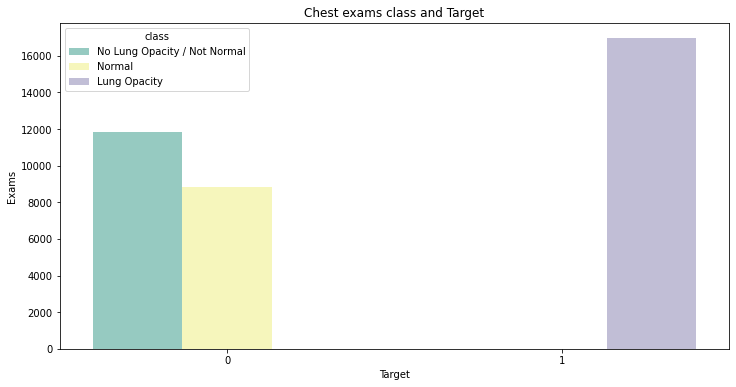

In [52]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df, palette='Set3')
plt.title("Chest exams class and Target")
plt.show()

In [ ]:
## All chest examinations withTarget = 1 (pathology detected) associated with class: Lung Opacity.

In [39]:
##Explore DICOM data

In [40]:
image_sample_path = os.listdir(PATH+'/stage_2_train_images')[:5]
print(image_sample_path)

['f694c8f4-978d-484d-be6f-e201c64a0206.dcm', 'f7314793-6863-4d4c-b090-a29308443ba7.dcm', 'f6fc2565-6f6c-4f0c-9a4f-c367ef4cacf0.dcm', 'f7d0ac07-d563-4dde-b27b-0fad32e59274.dcm', 'f7b3faca-1b1d-4428-9dc2-086106c871bf.dcm']


In [41]:
image_train_path = os.listdir(PATH+'/stage_2_train_images')
image_test_path = os.listdir(PATH+'/stage_2_test_images')
print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))

Number of images in train set: 26684 
Number of images in test set: 3000


In [42]:
##Check duplicates in train dataset

In [43]:
print("Unique patientId in  train_class_df: ", train_class_df['patientId'].nunique())    

Unique patientId in  train_class_df:  26684


In [44]:
##DICOM meta data

In [45]:
samplePatientID = list(train_class_df[:3].T.to_dict().values())[0]['patientId']
samplePatientID = samplePatientID+'.dcm'
dicom_file_path = os.path.join(PATH,"stage_2_train_images/",samplePatientID)
dicom_file_dataset = dcm.read_file(dicom_file_path)
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [53]:
## Plot DICOM images with Target = 1

In [54]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

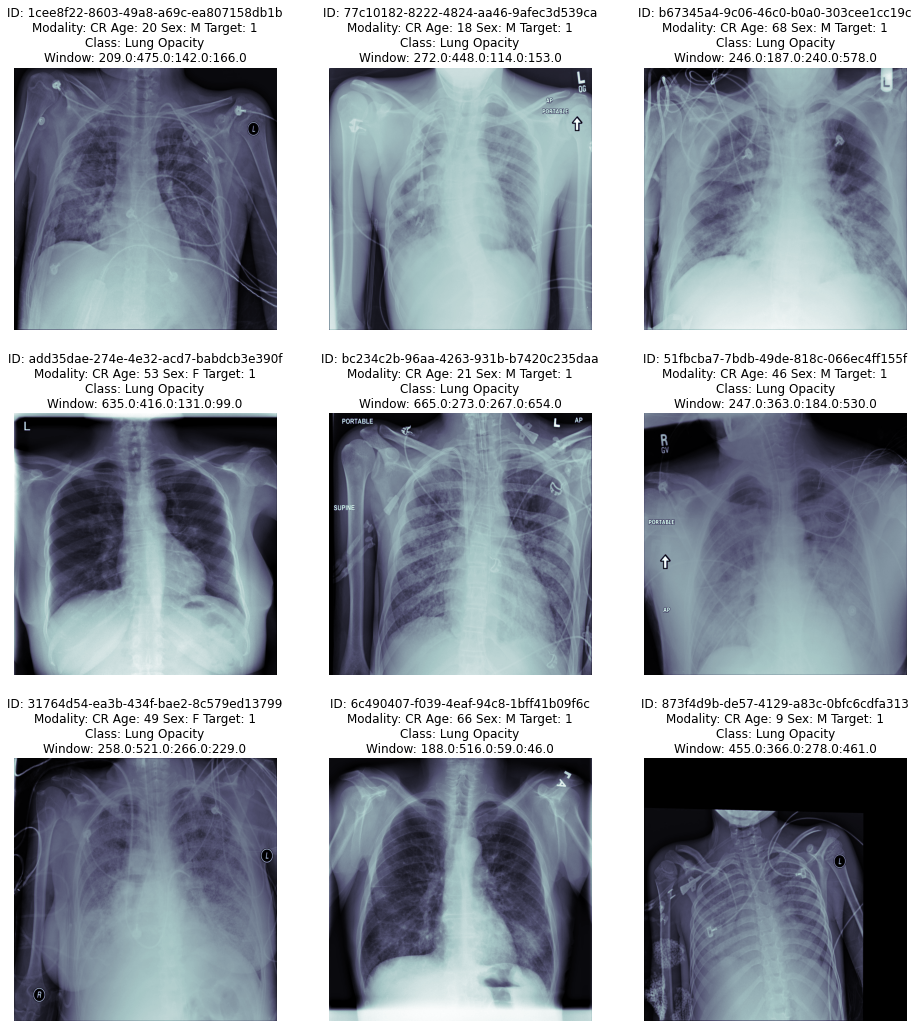

In [55]:
show_dicom_images(train_class_df[train_class_df['Target']==1].sample(9))

In [56]:
 ## represent the images with the overlay boxes superposed. For this, we will need first to parse the whole dataset with Target = 1  the windows showing a Lung Opacity on the same image

In [57]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()

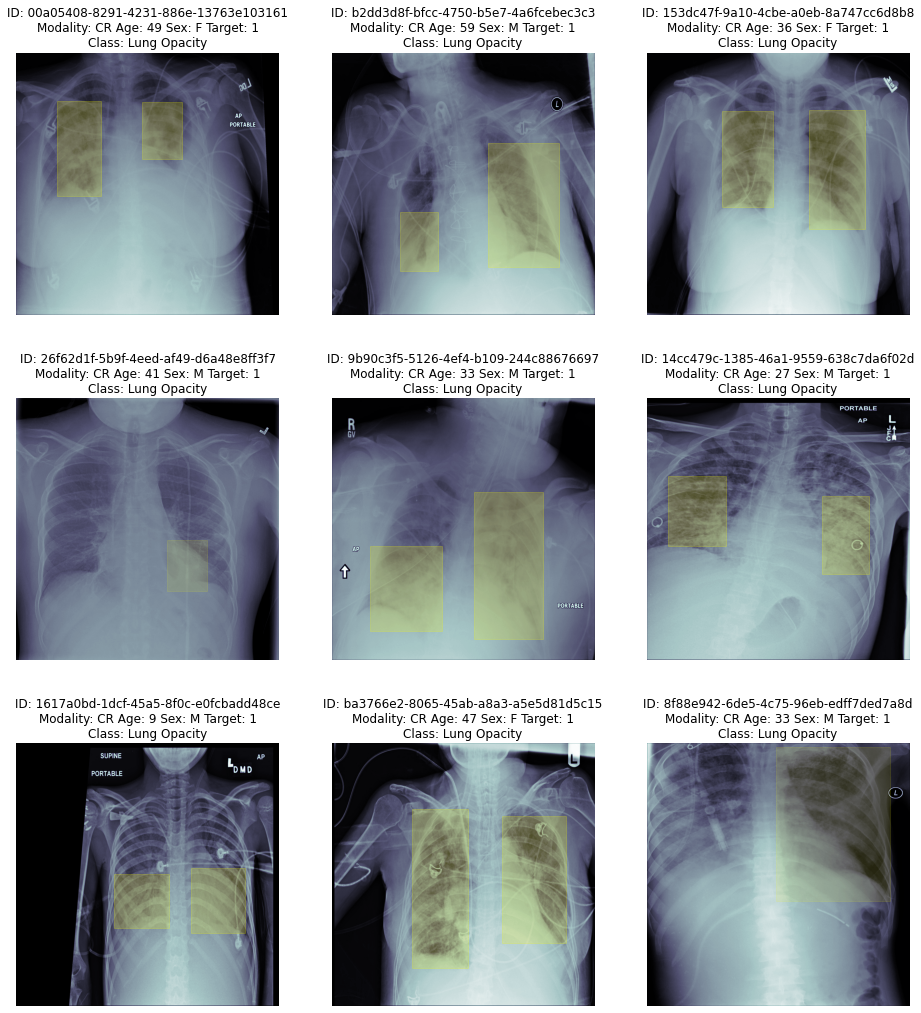

In [58]:
show_dicom_images_with_boxes(train_class_df[train_class_df['Target']==1].sample(9))

In [59]:
## sample few images having the Target = 0 non lung opacity

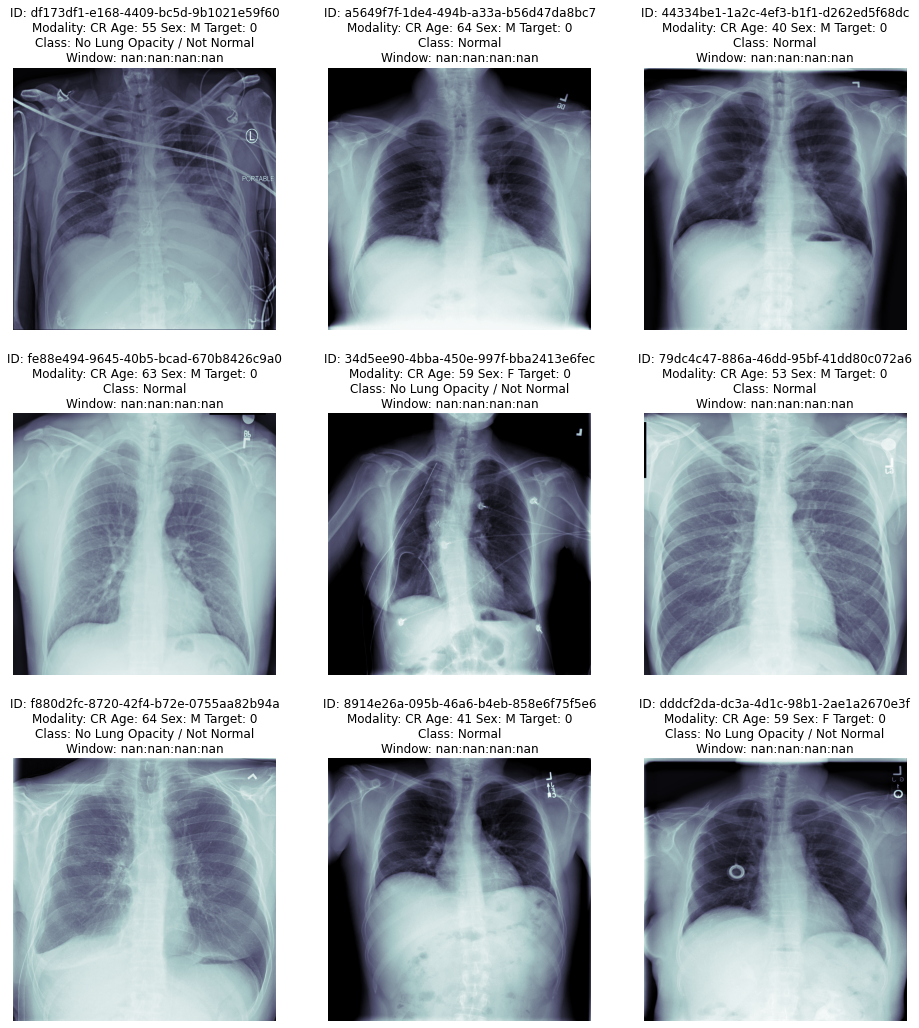

In [60]:
show_dicom_images(train_class_df[train_class_df['Target']==0].sample(9))